# First trial to open XRD data

The data is structured in hdf5 format so we need to install (once) the Python package from Andrew Colette with `%pip install h5py` and restart the kernel. 

In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.signal as ssg
import skimage.exposure as ske

## XRD hdf5 data explorations 

In [3]:
#!tree ..

In [4]:
h5_files = glob('../**/*.h5', recursive=True)
for i, fn in enumerate(h5_files): 
    print(f'[{i}] {fn}')

[0] ../data/raw/XRD/IvdW_0333329_01/IvdW_0333329_01_roi91399_107460/IvdW_0333329_01_roi91399_107460.h5
[1] ../data/raw/XRD/IvdW_1038646_1/IvdW_1038646_1_roi91400_107461/IvdW_1038646_1_roi91400_107461.h5
[2] ../data/raw/XRD/IvdW_90_12_X5/IvdW_90_12_X5_roi91398_107459/IvdW_90_12_X5_roi91398_107459.h5
[3] ../data/XRD/IvdW_0333329_01/IvdW_0333329_01_roi91399_107460/IvdW_0333329_01_roi91399_107460.h5
[4] ../data/XRD/IvdW_1038646_1/IvdW_1038646_1_roi91400_107461/IvdW_1038646_1_roi91400_107461.h5
[5] ../data/XRD/IvdW_90_12_X5/IvdW_90_12_X5_roi91398_107459/IvdW_90_12_X5_roi91398_107459.h5


Ok, let's take a look at the content of the **second** file for sample `IvdW_1038646_1`. 

In [5]:
fh = h5py.File(h5_files[1], mode='r')

In [6]:
list_of_names = []
fh.visit(list_of_names.append)
list_of_names

['1.1',
 '1.1/eiger_average',
 '1.1/eiger_average/average',
 '1.1/eiger_average/average/2th',
 '1.1/eiger_average/average/average_intensity',
 '1.1/eiger_average/average/reference_hydrocerussite',
 '1.1/eiger_diffmap',
 '1.1/eiger_diffmap/configuration',
 '1.1/eiger_diffmap/configuration/data',
 '1.1/eiger_diffmap/configuration/type',
 '1.1/eiger_diffmap/dim0',
 '1.1/eiger_diffmap/dim1',
 '1.1/eiger_diffmap/dim2',
 '1.1/eiger_diffmap/mask_file',
 '1.1/eiger_diffmap/offset',
 '1.1/eiger_diffmap/program',
 '1.1/eiger_diffmap/result',
 '1.1/eiger_diffmap/result/2th',
 '1.1/eiger_diffmap/result/intensity',
 '1.1/eiger_diffmap/result/map',
 '1.1/eiger_integrate',
 '1.1/eiger_integrate/configuration',
 '1.1/eiger_integrate/configuration/data',
 '1.1/eiger_integrate/configuration/type',
 '1.1/eiger_integrate/integrated',
 '1.1/eiger_integrate/integrated/2th',
 '1.1/eiger_integrate/integrated/intensity',
 '1.1/eiger_integrate/integrated/points',
 '1.1/eiger_integrate/program',
 '1.1/eiger_inte

We start our analysis with the `eiger_diffmap/result/2th` and `eiger_diffmap/result/intensity` datasets. 

In [7]:
intensity = np.array(fh['1.1/eiger_diffmap/result/intensity']) 
x = np.array(fh['1.1/eiger_integrate/integrated/2th'])

intensity = intensity.transpose([1, 0, 2]) #rotate 90 degrees to match microscopy images
intensity.shape

(310, 160, 1400)

In [8]:
sum_spectrum = np.average(intensity.reshape([-1, 1400]), axis=0)
min_spectrum = np.min(intensity.reshape([-1, 1400]), axis=0)
sum_spectrum.shape

(1400,)

Each pixel contains a diffractogram or 'spectrum'. Let's explore the data in a few plots. 

In [9]:
%matplotlib inline

Text(0.5, 0, '2$\\theta$')

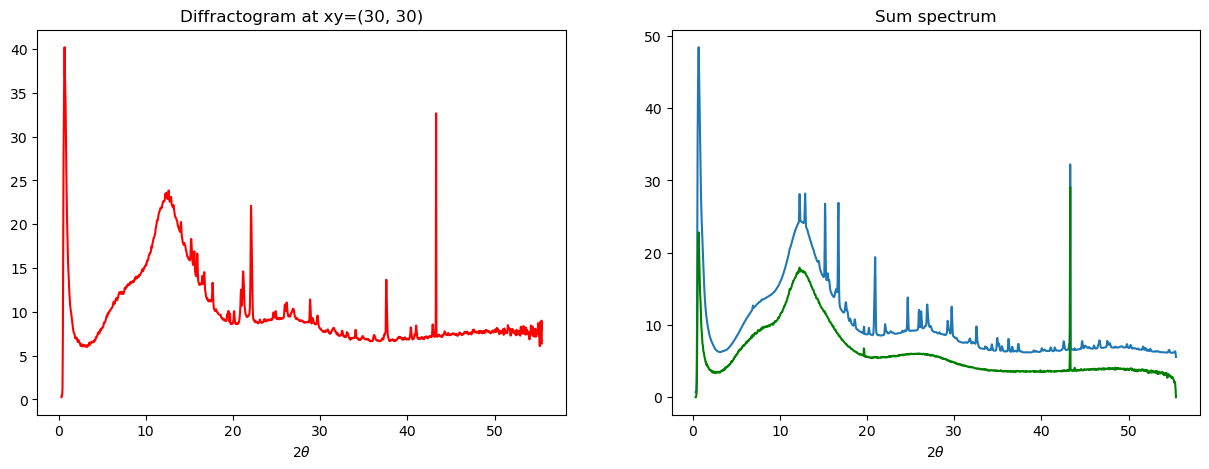

In [10]:
fig, [ax, ax1] = plt.subplots(ncols=2, squeeze=True, figsize=[15, 5])


ax.plot(x, intensity[30, 30], color='r')
ax.set_title('Diffractogram at xy=(30, 30)')
ax.set_xlabel(r'2$\theta$')

ax1.plot(x, sum_spectrum)
ax1.plot(x, min_spectrum, color='g')
ax1.set_title('Sum spectrum')
ax1.set_xlabel(r'2$\theta$')

Let's have a look at the 'sum map'. 

In [11]:
sum_map = np.sum(intensity, axis=2)
sum_map.shape

(310, 160)

Text(0.5, 1.0, 'IvdW_1038646_1 Sum map')

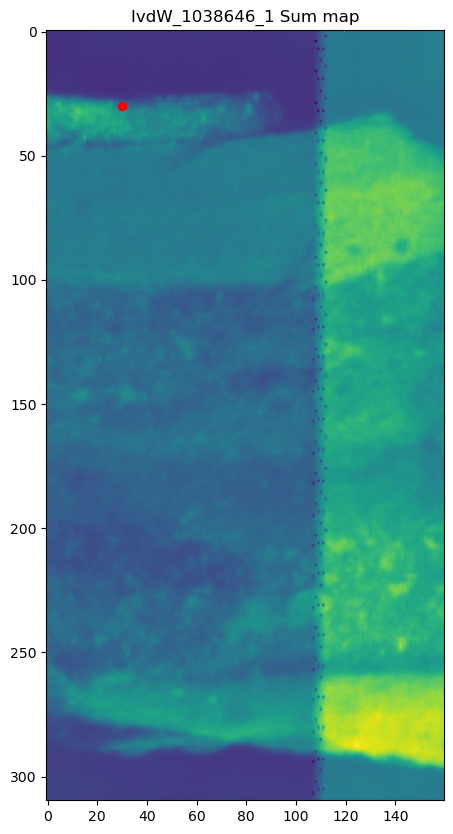

In [12]:
fig, ax = plt.subplots(figsize=[10, 10])
ax.imshow(sum_map)
ax.scatter(30, 30, color='r')
ax.set_title('IvdW_1038646_1 Sum map')

For this specific sample `IvdW_1038646_1` we see that there is a sudden problem with the overall  intensity. Let's save this sum map as a destination for image registration.

In [51]:
plt.imsave('../data/interim/IvdW_1038646_1_sum-map.png', sum_map)

The max spectrum is another useful representation. 

In [52]:
plt.close('all')

In [13]:
max_spectrum = np.max(intensity.reshape([-1, 1400]), axis=0)
max_spectrum.shape

(1400,)

In [14]:
peak_idxs = ssg.find_peaks(max_spectrum, prominence=5)[0]
len(peak_idxs)

161

In [15]:
plt.close('all')

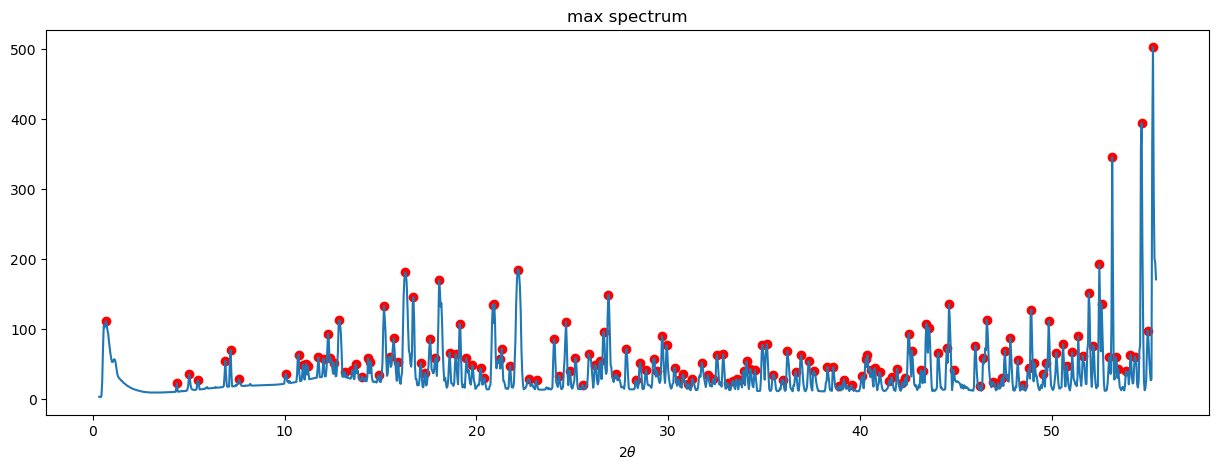

In [16]:
fig, ax = plt.subplots(figsize=[15, 5])
ax.plot(x, max_spectrum)
ax.set_xlabel(r'2$\theta$')
ax.set_title('max spectrum') 

ax.scatter(x[peak_idxs], max_spectrum[peak_idxs], color='r')

In [17]:
peak_maps = [intensity[:,:, peak_i] for peak_i in peak_idxs]

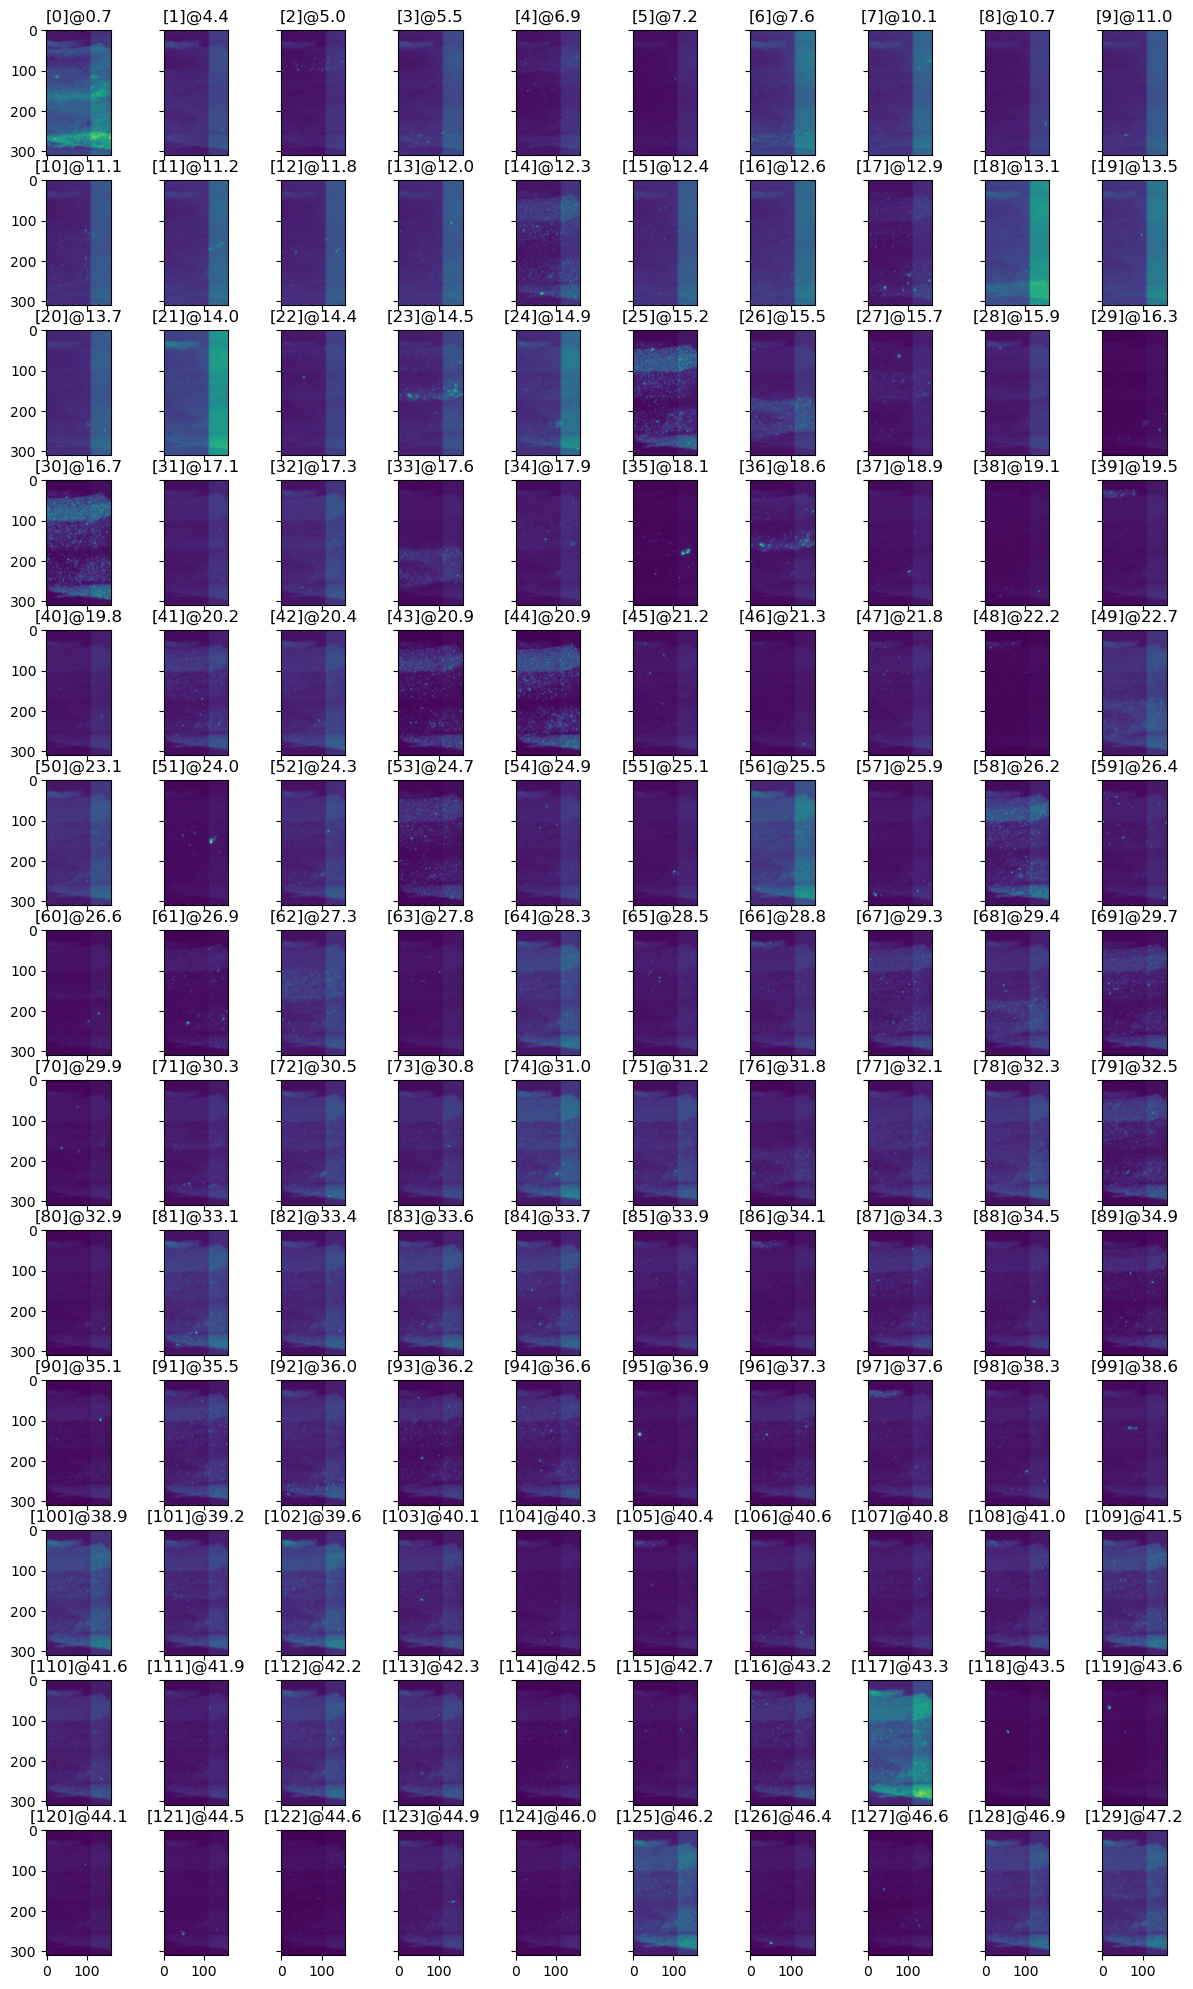

In [18]:
fig, axs = plt.subplots(nrows=13, ncols=10, sharex=True, sharey=True, figsize=[15, 25])
axs = axs.flatten()

for i, [ax, m] in enumerate(zip(axs, peak_maps)): 
 
    ax.imshow(m)
    ax.set_title(f'[{i}]@{x[peak_idxs[i]]:.1f}')

plt.subplots_adjust(wspace=0.1, hspace=0.2)

In [64]:
r = peak_maps[0]
g = peak_maps[25]
b = peak_maps[117]

r = (r - r.min()) / r.ptp()
g = (g - g.min()) / g.ptp()
b = (b - b.min()) / b.ptp() 

r = ske.equalize_hist(r)
g = ske.equalize_hist(g)
b = ske.equalize_hist(b)

rgb = np.dstack([r, g, b])

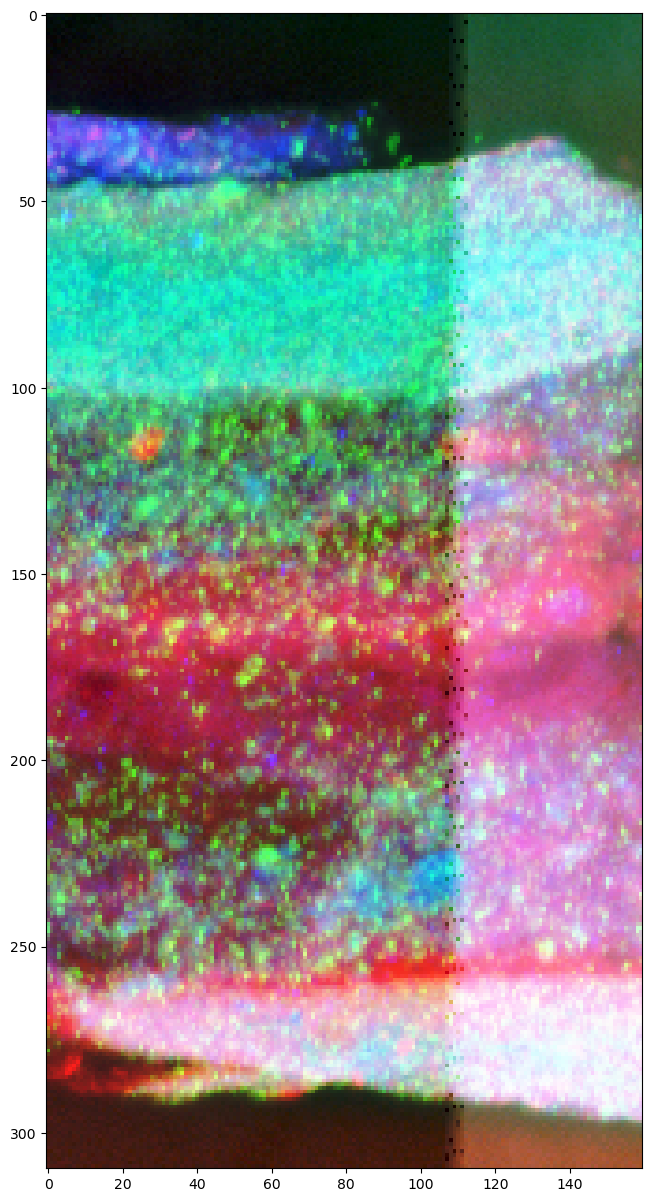

In [65]:
fig, ax = plt.subplots(figsize=[10, 15])

ax.imshow(rgb)


In [66]:
plt.imsave('../data/interim/IvdW_1038646_1_rgb.png', rgb)

In [21]:
is_max = p8 == p8.max() 
i, j = np.argwhere(is_max).flatten()

In [22]:
peak_spectrum = intensity[i, j]
i, j

(128, 71)

Text(0.5, 1.0, 'peak spectrum 8')

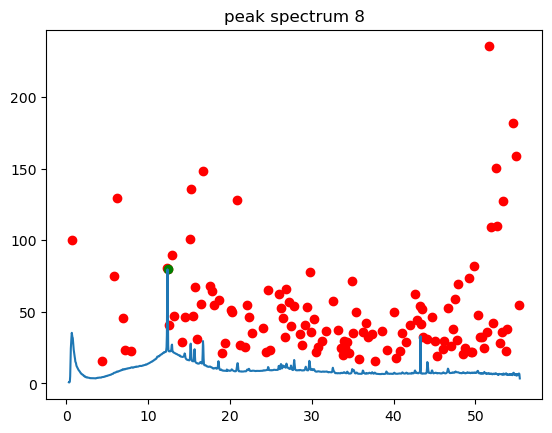

In [23]:
fig, ax = plt.subplots()
ax.plot(x, peak_spectrum)
ax.scatter(x[peak_idxs], max_spectrum[peak_idxs], color='r')
ax.scatter(x[peak_idxs[8]], max_spectrum[peak_idxs[8]], color='g')

ax.set_title('peak spectrum 8')

In [24]:
plt.close('all')

In [25]:
is_leuke_piek = (x < 16.8) * (x > 16.6)
is_leuke_piek

array([False, False, False, ..., False, False, False])

In [26]:
piek_slice = intensity[:, :, is_leuke_piek]
piek_slice.shape

(170, 110, 5)

In [27]:
integrated_slice = np.sum(piek_slice, axis=2)

Text(0.5, 1.0, 'Integrated slice $ 16.6\\degree < 2\\theta < 16.8\\degree $')

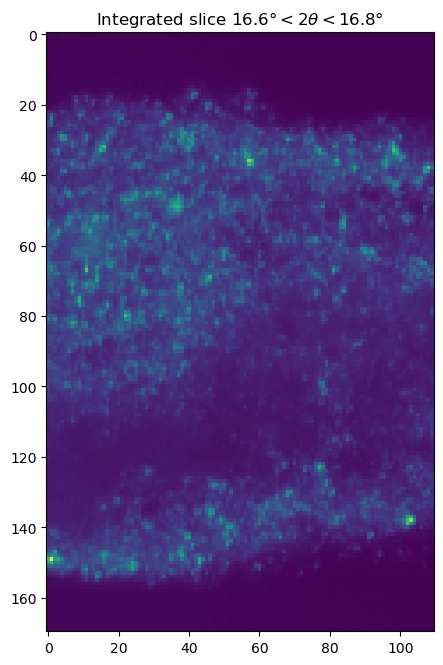

In [28]:
fig, ax = plt.subplots(figsize=[5, 10])
ax.imshow(integrated_slice)
ax.set_title('Integrated slice $ 16.6\\degree < 2\\theta < 16.8\\degree $')

In [29]:
import scipy.signal as ssg

In [30]:
peak_idxs = ssg.find_peaks(max_spectrum)[0]
peak_idxs

array([   6,    9,   11,   19,   49,   51,   70,   75,   80,   95,   97,
        100,  104,  107,  110,  119,  122,  130,  135,  140,  145,  149,
        154,  163,  167,  174,  177,  182,  185,  188,  192,  194,  197,
        200,  204,  208,  213,  218,  221,  226,  236,  241,  251,  264,
        270,  274,  282,  285,  297,  299,  303,  306,  312,  319,  327,
        335,  341,  347,  352,  360,  364,  377,  379,  385,  390,  396,
        406,  408,  411,  416,  421,  426,  431,  438,  445,  451,  465,
        472,  475,  478,  483,  490,  496,  502,  505,  508,  512,  521,
        531,  538,  542,  545,  552,  559,  568,  574,  583,  587,  591,
        593,  597,  603,  610,  618,  623,  628,  637,  643,  646,  651,
        657,  664,  670,  675,  684,  689,  695,  699,  706,  711,  717,
        721,  723,  734,  738,  747,  752,  761,  767,  773,  776,  780,
        786,  789,  793,  797,  800,  804,  809,  814,  819,  831,  836,
        843,  849,  854,  858,  864,  869,  879,  8

## Microscopy images 

In [1]:
!tree ..

..
├── data
│   ├── AMCSD-data
│   │   ├── CdCO3-variations
│   │   │   ├── Otavite_0000103.cif
│   │   │   ├── Otavite_0004324.cif
│   │   │   ├── Otavite_0004339.cif
│   │   │   └── Otavite_0018091.cif
│   │   └── CdS-variations
│   │       ├── Greenockite_0011540.cif
│   │       ├── Greenockite_0015177.cif
│   │       ├── Greenockite_0017955.cif
│   │       ├── Hawleyite_0000070.cif
│   │       ├── Hawleyite_0000111.cif
│   │       ├── Hawleyite_0011517.cif
│   │       ├── Hawleyite_0018113.cif
│   │       └── Hawleyite_0018121.cif
│   ├── interim
│   │   ├── IvdW_0333329_01_sum-map.png
│   │   ├── IvdW_1038646_1_baselines.pkl
│   │   ├── IvdW_1038646_1_new-rgb.png
│   │   ├── IvdW_1038646_1_polypol.png
│   │   ├── IvdW_1038646_1_rgb.png
│   │   └── IvdW_1038646_1_sum-map.png
│   ├── microscopy
│   │   ├── 1038646-1
│   │   └── xrdfotosomvisuvensem
│   ├── raw
│   │   ├── microscopy
│   │   │   ├── 1038646-1
│   │   │   │   ├── 1038646-1_1_screenshot-ESRF.png
│   │   │   │   ├── 103

In [5]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

In [3]:
micros_files = glob('../**/1038646-1/*.*', recursive=True)
micros_files

['../data/raw/microscopy/1038646-1/1038646-1 UV 20x.jpg',
 '../data/raw/microscopy/1038646-1/1038646-1 VIS 20x.jpg',
 '../data/raw/microscopy/1038646-1/1038646-1_1.tif',
 '../data/raw/microscopy/1038646-1/1038646-1_1_screenshot-ESRF.png',
 '../data/raw/microscopy/1038646-1/1038646-1_registration.svg']

In [68]:
%matplotlib widget

In [33]:
micros_ims = [plt.imread(im) for im in micros_files]

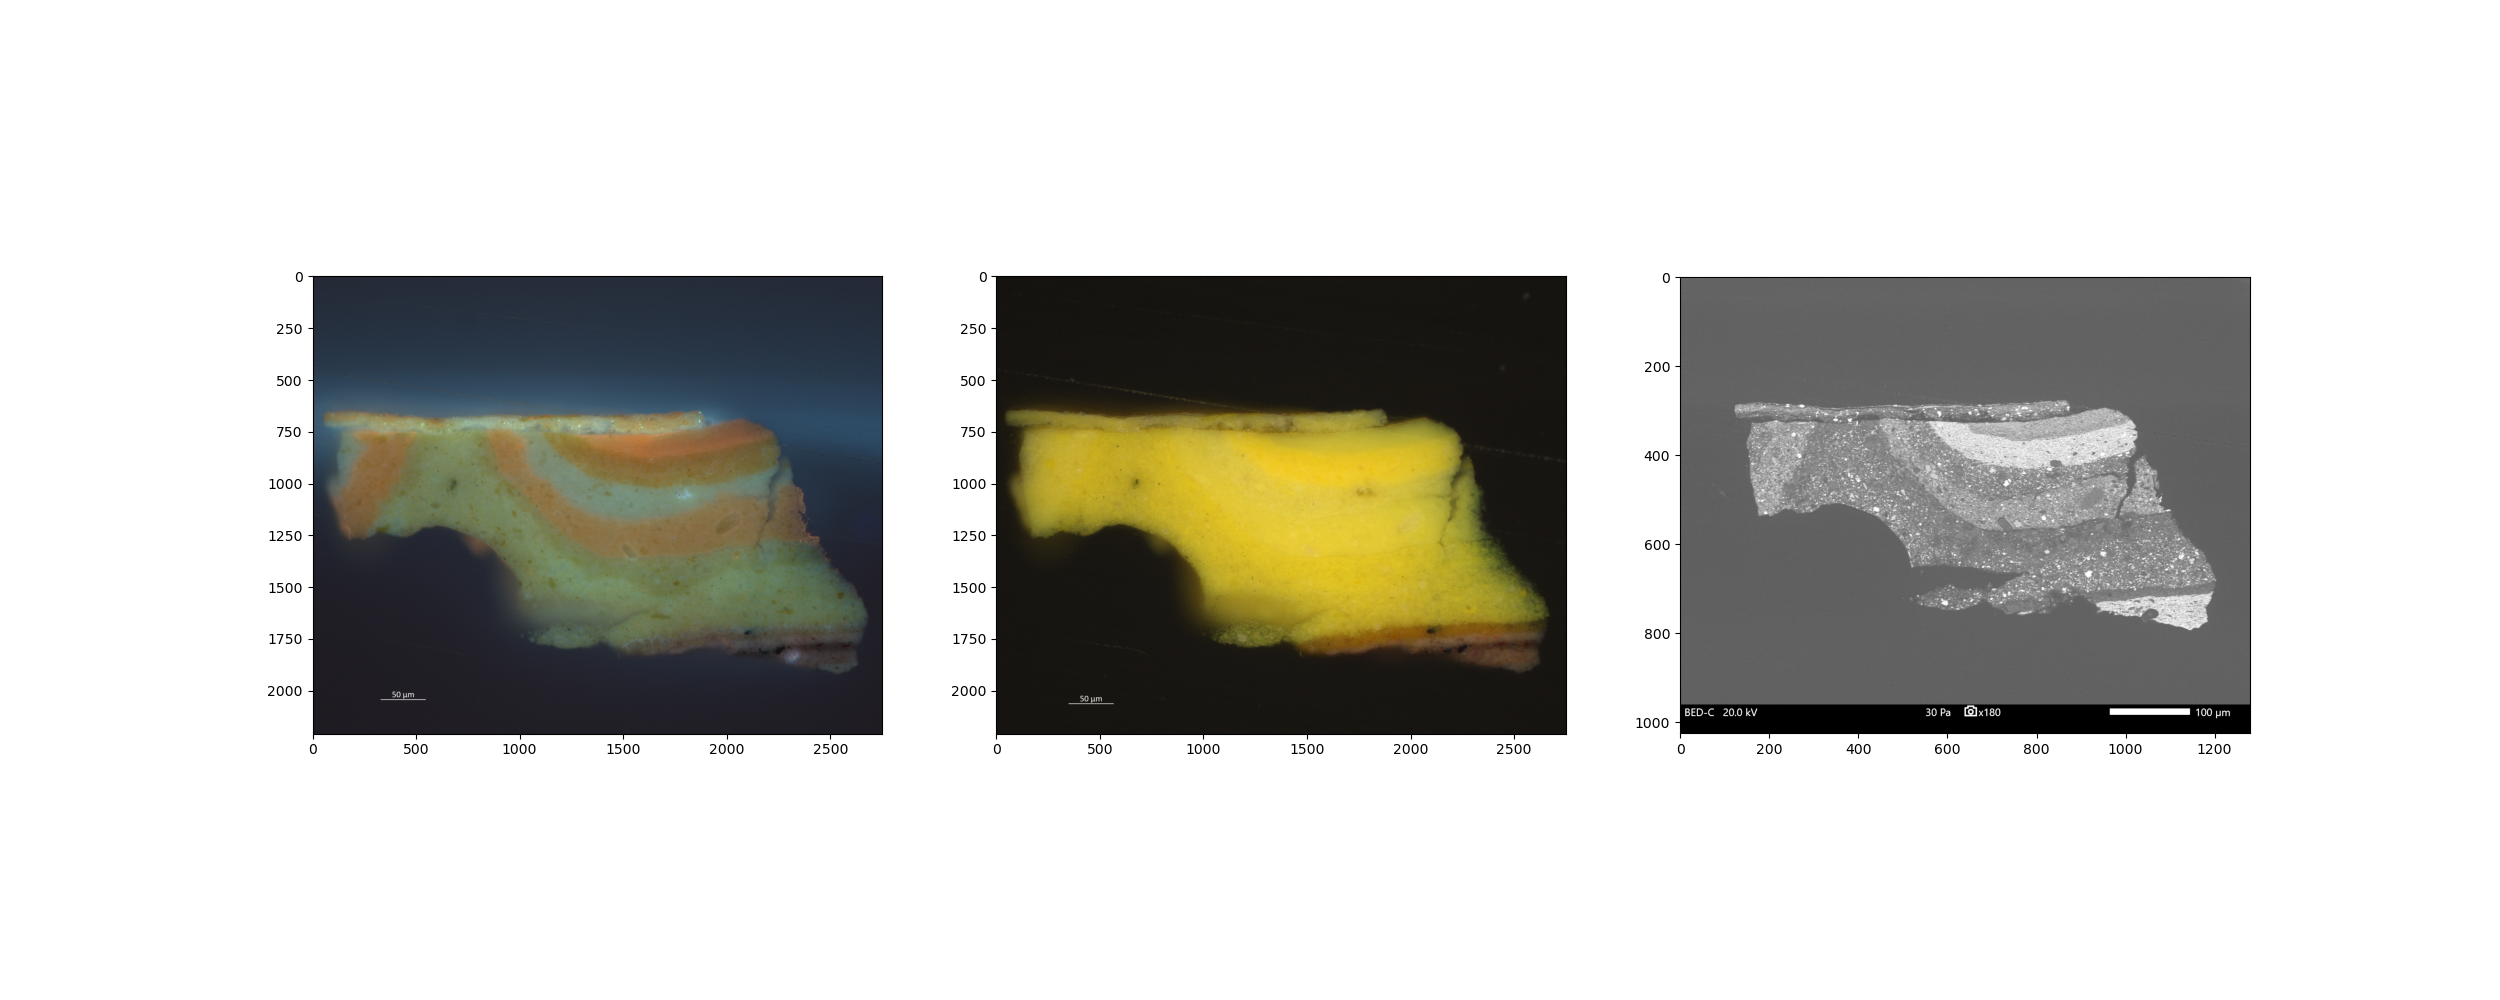

In [70]:
fig, axs = plt.subplots(ncols=3, figsize=[25, 10], squeeze=True)

for ax, im in zip(axs, micros_ims): 
    ax.imshow(im, cmap='Greys_r')
    

## Crystallography...

[Crystallography Open Database](http://www.crystallography.net/cod/)

In [11]:
im = plt.imread(micros_files[0])

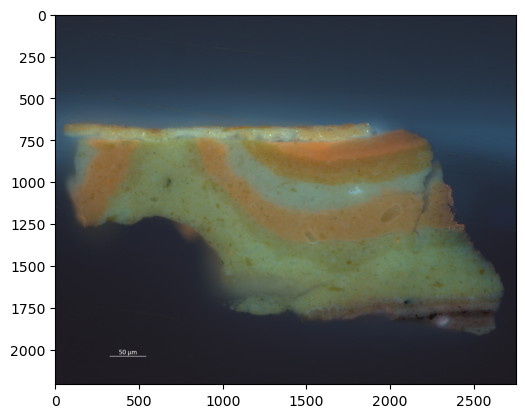

In [12]:
fig, ax = plt.subplots()
ax.imshow(im)

In [8]:
plt.imsave('test.jpg', im)

In [9]:
!ls

01_how-not-to-open-with-PyMCA.ipynb
02_opening-XRD-hdf5-data.ipynb
03_image-registration-with-maxrf4u.ipynb
04_XRD-with-NMF.ipynb
04_XRD-with-NMF-or-UMAP.ipynb
05_cif-to-diffractogram.ipynb
06_creating-a-crystallography-table.html
06_creating-a-crystallography-table.ipynb
test.jpg


In [13]:
im.shape

(2208, 2752, 3)

In [15]:
im

array([[[36, 40, 51],
        [35, 39, 50],
        [35, 39, 51],
        ...,
        [35, 38, 53],
        [36, 39, 54],
        [38, 41, 56]],

       [[37, 41, 52],
        [36, 40, 51],
        [35, 39, 51],
        ...,
        [36, 39, 54],
        [36, 39, 54],
        [36, 39, 54]],

       [[38, 44, 56],
        [37, 43, 55],
        [38, 42, 54],
        ...,
        [38, 42, 54],
        [38, 42, 54],
        [36, 40, 52]],

       ...,

       [[30, 27, 34],
        [31, 28, 35],
        [32, 29, 36],
        ...,
        [30, 28, 33],
        [30, 28, 33],
        [29, 27, 32]],

       [[30, 27, 34],
        [30, 27, 34],
        [31, 28, 35],
        ...,
        [29, 27, 32],
        [30, 28, 33],
        [31, 29, 34]],

       [[31, 28, 35],
        [30, 27, 34],
        [30, 27, 34],
        ...,
        [28, 26, 31],
        [30, 28, 33],
        [33, 31, 36]]], dtype=uint8)